In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [21]:
df = pd.read_csv("data.csv")
df.set_index("Minute", inplace=True)

x = np.array(df.index)
y = np.array(df["Output (kW)"])

## Polynomial Interpolation

## Newton's Interpolation

In [22]:
def divided_diff(x, y):
    """
    function to calculate the divided
    differences table
    """
    n = len(y)
    coef = np.zeros([n, n])
    # the first column is y
    coef[:, 0] = y

    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])

    return coef


def newton_poly(y_data, x_data, x, power):
    """
    evaluate the newton polynomial
    at x
    """
    coef = divided_diff(x_data, y_data)[0, :]


    p = coef[power]
    for k in range(1, power + 1):
        p = coef[power - k] + (x - x_data[power - k]) * p
    return p

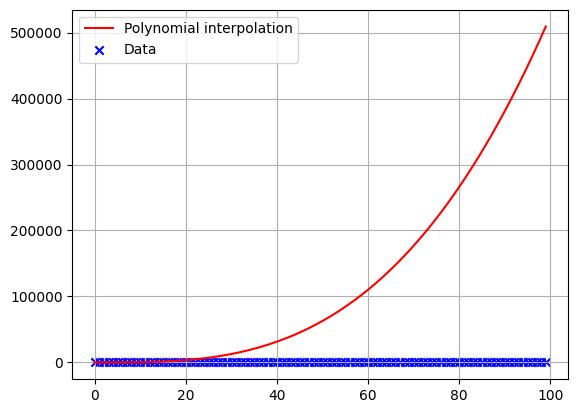

In [23]:
new_x = np.linspace(x[0], x[-1], 200)
y_hat = newton_poly(y, x, new_x, 3)

plt.plot(new_x, y_hat, label="Polynomial interpolation", color="r")
plt.scatter(x, y, label="Data", marker="x", color="b")
# plt.axis([x[0], x[-1], y[0], y[-1]])
plt.legend()
plt.grid()
plt.show()

## Lagrange's Interpolation

In [24]:
def lagrange_interpolating(X, Y, order, new_X_array):
    interpolated_values = []

    for new_X in new_X_array:
        # Find the index of the first X >= new_X
        for i in range(len(X)):
            if X[i] >= new_X:
                idx_new = i
                break
        else:
            idx_new = len(X)  # If new_X is larger than all elements, use the last point

        # Ensure there are enough points around new_X for interpolation
        n = order + 1  # We need n points for an (n-1)th order polynomial

        # Handle boundary conditions when choosing the subset
        subs_idx_bot = max(0, idx_new - math.ceil(n / 2))
        subs_idx_top = min(len(X), idx_new + math.floor(n / 2))

        # Get the subset of points around new_X for interpolation
        X_subset = X[subs_idx_bot:subs_idx_top]
        Y_subset = Y[subs_idx_bot:subs_idx_top]

        # Interpolated value at new_X
        interpolated_value = 0

        # Loop over the subset of points
        for i in range(len(X_subset)):
            # Compute the Lagrange basis polynomial L_i(x)
            L_i = 1
            for j in range(len(X_subset)):
                if i != j:
                    L_i *= (new_X - X_subset[j]) / (X_subset[i] - X_subset[j])

            # Add the contribution of Y_subset[i] * L_i(x) to the total interpolation
            interpolated_value += Y_subset[i] * L_i

        # Append the result for this new_X to the list
        interpolated_values.append(interpolated_value)

    return np.array(interpolated_values)

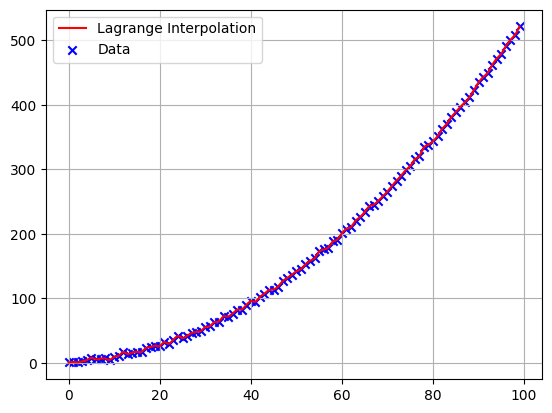

In [25]:
new_x = np.arange(0, 99.5, 0.5)
y_hat = lagrange_interpolating(x, y, 3, new_x)

plt.plot(new_x, y_hat, label="Lagrange Interpolation", color="r")
plt.scatter(x, y, label="Data", marker="o", color="b")
# plt.axis([x[0], x[-1], y[0], y[-1]])
plt.legend()
plt.grid()
plt.show()

## Spline Interpolation

In [26]:
def spline_interpolation(x, y):
    n = len(x)
    if n != len(y):
        raise ValueError("x dan y harus memiliki panjang yang sama.")

    # Koefisien spline
    a = np.copy(y)  # a adalah nilai y
    b = np.zeros(n)  # b adalah koefisien linear
    c = np.zeros(n)  # c adalah koefisien kuadratik
    d = np.zeros(n)  # d adalah koefisien kubik

    # Menghitung interval dan matriks sistem
    h = np.diff(x)
    alpha = np.zeros(n)
    
    for i in range(1, n - 1):
        alpha[i] = (3/h[i]) * (a[i + 1] - a[i]) - (3/h[i - 1]) * (a[i] - a[i - 1])
    
    # Membuat matriks tridiagonal
    l = np.ones(n)
    mu = np.zeros(n)
    z = np.zeros(n)

    for i in range(1, n - 1):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]

    l[n - 1] = 1
    z[n - 1] = 0
    c[n - 1] = 0

    for j in range(n - 2, -1, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
        b[j] = (a[j + 1] - a[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d[j] = (c[j + 1] - c[j]) / h[j]

    def spline(x_val):
        # Memperbolehkan ekstrapolasi
        if x_val < x[0]:
            # Ekstrapolasi ke kiri
            i = 0
        elif x_val > x[-1]:
            # Ekstrapolasi ke kanan
            i = n - 2
        else:
            # Mencari interval
            i = np.searchsorted(x, x_val) - 1
            if i < 0:
                i = 0
            elif i >= n - 1:
                i = n - 2
        
        dx = x_val - x[i]

        return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3

    return spline

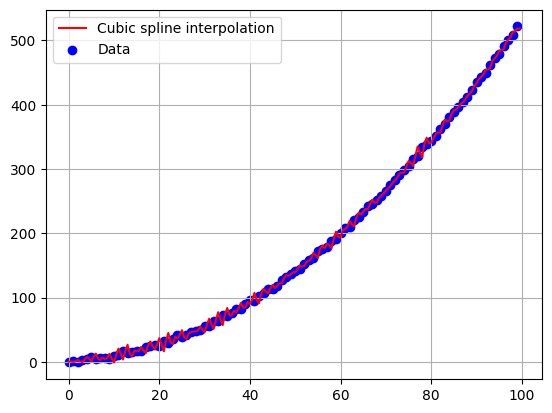

In [27]:
f = spline_interpolation(x, y)

new_x = np.arange(0, 100, 0.5)
y_hat = np.array([f(i) for i in new_x])

df = pd.DataFrame({"x": new_x, "y": y_hat})
df.to_csv("spline1.csv", index=False)


plt.plot(new_x, y_hat, label="Cubic spline interpolation", color="r")
plt.scatter(x, y, label="Data", marker="o", color="b")
# plt.axis([x[0], x[5], y[0], y[5]])
plt.legend()
plt.grid()
plt.show()

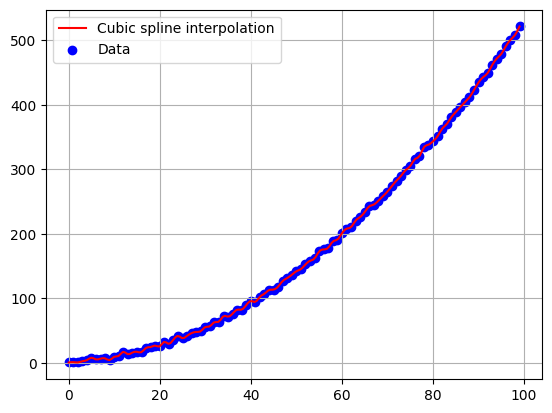

In [28]:
from scipy.interpolate import CubicSpline

f = CubicSpline(x, y, bc_type="natural")
x_eval = np.linspace(x[0], x[-1], 200)
y_eval = f(x_eval)

df = pd.DataFrame({"x": x_eval, "y": y_eval})
df.to_csv("spline.csv", index=False)

plt.plot(x_eval, y_eval, label="Cubic spline interpolation", color="r")
plt.scatter(x, y, label="Data", marker="o", color="b")
# plt.axis([x[0], x[5], y[0], y[5]])
plt.legend()
plt.grid()
plt.show()